In [14]:
!pip install polygon-api-client pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 1.7 MB/s eta 0:00:00


In [36]:
from polygon import RESTClient
import pandas as pd

API_KEY = '37QxP1uso5LJAr0wIOCMyZmvPzNrljlH'
client = RESTClient(API_KEY)

symbol = "AAPL"
from_date = "2023-01-01"
to_date = "2023-07-01"

try:
    response = client.get_aggs(ticker=symbol, multiplier=1, timespan='day', from_=from_date, to=to_date)

    if response:
        df = pd.DataFrame(response)

        print("Response keys:", df.columns)

        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)

            print(df.head())
        else:
            print("Expected timestamp field 'timestamp' not found in response.")
    else:
        print(f"No data available for {symbol} from {from_date} to {to_date}.")
except Exception as e:
    print("An error occurred while fetching data:", str(e))

Response keys: Index(['open', 'high', 'low', 'close', 'volume', 'vwap', 'timestamp',
       'transactions', 'otc'],
      dtype='object')
                        open      high     low   close       volume      vwap  \
timestamp                                                                       
2023-01-03 05:00:00  130.280  130.9000  124.17  125.07  112117471.0  125.7250   
2023-01-04 05:00:00  126.890  128.6557  125.08  126.36   89100633.0  126.6464   
2023-01-05 05:00:00  127.130  127.7700  124.76  125.02   80716808.0  126.0883   
2023-01-06 05:00:00  126.010  130.2900  124.89  129.62   87754715.0  128.1982   
2023-01-09 05:00:00  130.465  133.4100  129.89  130.15   70790813.0  131.6292   

                     transactions   otc  
timestamp                                
2023-01-03 05:00:00       1021065  None  
2023-01-04 05:00:00        770042  None  
2023-01-05 05:00:00        665458  None  
2023-01-06 05:00:00        711520  None  
2023-01-09 05:00:00        645365  None  


In [37]:
df['Returns'] = df['close'].pct_change()

X = df[['open', 'high', 'low', 'close', 'volume']].fillna(0).values
y = (df['Returns'] > 0).astype(int).values

df.dropna(inplace=True)

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"Model accuracy: {accuracy:.2f}")

Model accuracy: 0.58


In [41]:
# Calculate daily returns
df['Returns'] = df['close'].pct_change()

# Create feature set X and target variable y
X = df[['open', 'high', 'low', 'close', 'volume']].fillna(0).values
y = (df['Returns'] > 0).astype(int).values  # Binary target variable: 1 if return > 0, else 0

# Drop rows with NaN values
df.dropna(inplace=True)

In [42]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [44]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

# Evaluate the model
rf_accuracy = random_forest.score(X_test, y_test)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

Random Forest Accuracy: 1.00


In [46]:
from sklearn.neural_network import MLPClassifier

# Train the model
mlp = MLPClassifier(max_iter=1000)
mlp.fit(X_train, y_train)

# Evaluate the model
mlp_accuracy = mlp.score(X_test, y_test)
print(f"Neural Network Accuracy: {mlp_accuracy:.2f}")

Neural Network Accuracy: 1.00


In [50]:
# Predict on the test set
y_pred = model.predict(X_test)

# Display a classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [48]:
# Predict on the entire dataset for each model
df['DecisionTree_Pred'] = decision_tree.predict(X)
df['RandomForest_Pred'] = random_forest.predict(X)
df['MLP_Pred'] = mlp.predict(X)

# Calculate strategy returns based on predictions
df['DecisionTree_Strategy'] = df['DecisionTree_Pred'] * df['Returns']
df['RandomForest_Strategy'] = df['RandomForest_Pred'] * df['Returns']
df['MLP_Strategy'] = df['MLP_Pred'] * df['Returns']

# Calculate cumulative returns
df['Cumulative_Market_Returns'] = (1 + df['Returns']).cumprod()
df['Cumulative_DT_Returns'] = (1 + df['DecisionTree_Strategy']).cumprod()
df['Cumulative_RF_Returns'] = (1 + df['RandomForest_Strategy']).cumprod()
df['Cumulative_MLP_Returns'] = (1 + df['MLP_Strategy']).cumprod()

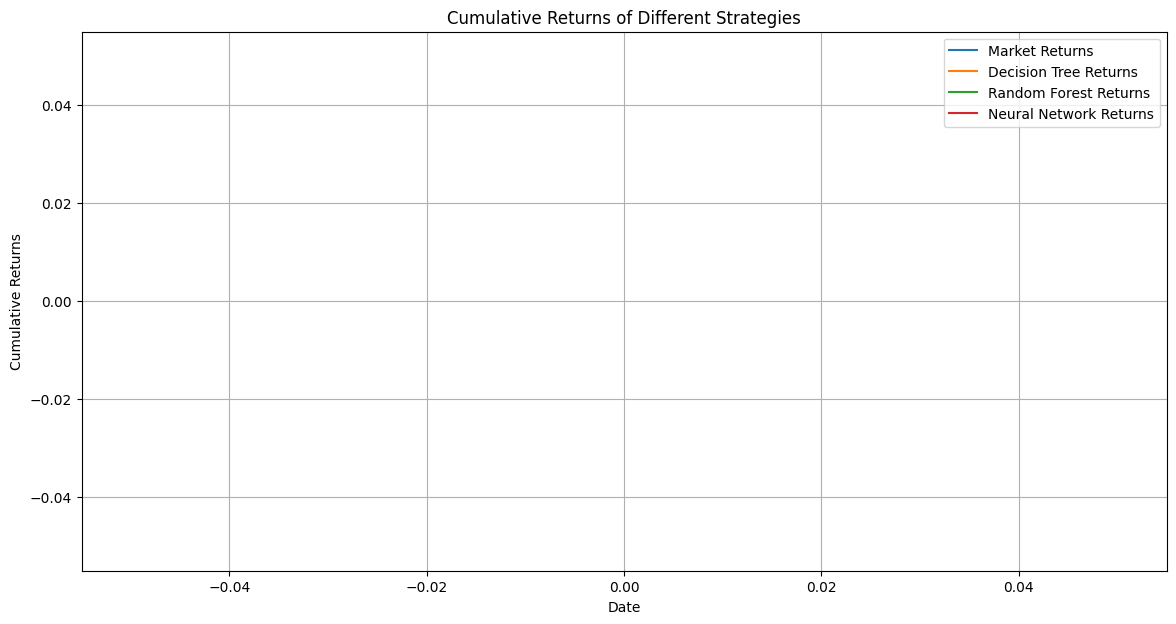

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Cumulative_Market_Returns'], label='Market Returns')
plt.plot(df.index, df['Cumulative_DT_Returns'], label='Decision Tree Returns')
plt.plot(df.index, df['Cumulative_RF_Returns'], label='Random Forest Returns')
plt.plot(df.index, df['Cumulative_MLP_Returns'], label='Neural Network Returns')

plt.title('Cumulative Returns of Different Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
import numpy as np

# Compute daily returns for each strategy
df['Strategy_DT'] = df['DecisionTree_Strategy']
df['Strategy_RF'] = df['RandomForest_Strategy']
df['Strategy_MLP'] = df['MLP_Strategy']

# Calculate cumulative returns
df['Cumulative_Strategy_DT'] = (1 + df['Strategy_DT']).cumprod()
df['Cumulative_Strategy_RF'] = (1 + df['Strategy_RF']).cumprod()
df['Cumulative_Strategy_MLP'] = (1 + df['Strategy_MLP']).cumprod()

# Sharpe Ratio
def calculate_sharpe(returns, risk_free_rate=0.01):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

# Max Drawdown
def calculate_max_drawdown(returns):
    peak = np.maximum.accumulate(returns)
    drawdown = (peak - returns) / peak
    return drawdown.max()

strategies = ['Strategy_DT', 'Strategy_RF', 'Strategy_MLP']
results = {}

for strategy in strategies:
    sharpe = calculate_sharpe(df[strategy].dropna())
    max_drawdown = calculate_max_drawdown(df['Cumulative_' + strategy].dropna())
    results[strategy] = {'Sharpe Ratio': sharpe, 'Max Drawdown': max_drawdown}

results


{'Strategy_DT': {'Sharpe Ratio': nan, 'Max Drawdown': nan},
 'Strategy_RF': {'Sharpe Ratio': nan, 'Max Drawdown': nan},
 'Strategy_MLP': {'Sharpe Ratio': nan, 'Max Drawdown': nan}}

In [53]:
# Define the calculation functions properly

def calculate_sharpe(returns, risk_free_rate=0.01):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

def calculate_max_drawdown(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (peak - cumulative_returns) / peak
    return drawdown.max()

# Ensure returns and cumulative returns are correctly computed
df['Cumulative_Returns'] = (1 + df['Returns']).cumprod()
strategies = ['Strategy_DT', 'Strategy_RF', 'Strategy_MLP']
results = {}

for strategy in strategies:
    strategy_returns = df[strategy].dropna()
    cumulative_returns = (1 + strategy_returns).cumprod()

    # Handle potential issues with empty or zero returns
    if not strategy_returns.empty and np.std(strategy_returns) != 0:
        sharpe = calculate_sharpe(strategy_returns)
        max_drawdown = calculate_max_drawdown(cumulative_returns)
        results[strategy] = {'Sharpe Ratio': sharpe, 'Max Drawdown': max_drawdown}
    else:
        results[strategy] = {'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan}

results

{'Strategy_DT': {'Sharpe Ratio': nan, 'Max Drawdown': nan},
 'Strategy_RF': {'Sharpe Ratio': nan, 'Max Drawdown': nan},
 'Strategy_MLP': {'Sharpe Ratio': nan, 'Max Drawdown': nan}}

In [54]:
print(df[['DecisionTree_Pred', 'RandomForest_Pred', 'MLP_Pred']].apply(pd.Series.value_counts))


   DecisionTree_Pred  RandomForest_Pred  MLP_Pred
0                124                124       124


In [55]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier()

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print(f"Best Random Forest parameters: {best_params_rf}")
print(f"Best Random Forest score: {best_score_rf:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Random Forest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best Random Forest score: 1.0000


In [58]:
from sklearn.neural_network import MLPClassifier

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'max_iter': [500, 1000]
}

mlp = MLPClassifier()

grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=5, n_jobs=-1, verbose=2)
grid_search_mlp.fit(X_train, y_train)

best_params_mlp = grid_search_mlp.best_params_
best_score_mlp = grid_search_mlp.best_score_

print(f"Best MLP parameters: {best_params_mlp}")
print(f"Best MLP score: {best_score_mlp:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best MLP parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'max_iter': 500, 'solver': 'adam'}
Best MLP score: 1.0000


In [59]:
optimized_rf = RandomForestClassifier(**best_params_rf)
optimized_rf.fit(X_train, y_train)

optimized_mlp = MLPClassifier(**best_params_mlp)
optimized_mlp.fit(X_train, y_train)

rf_accuracy = optimized_rf.score(X_test, y_test)
mlp_accuracy = optimized_mlp.score(X_test, y_test)

print(f"Optimized Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Optimized MLP Accuracy: {mlp_accuracy:.4f}")

Optimized Random Forest Accuracy: 1.0000
Optimized MLP Accuracy: 1.0000
